# [1D-BASELINE] Exp21: Velocity Test

Change graduation for 1.0 to 2.0 with 0.1 increment

## Import

In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

In [2]:
import pickle
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import datetime
import time
from IPython.display import clear_output

In [4]:
from grace.system import Grace
from grace.capture import LeftEyeCapture, RightEyeCapture
from grace.utils import get_center_chessboard_point, generate_triangle_wave

## Initialization

In [5]:
# Instantiation
grace = Grace(degrees=True)
left_cam = LeftEyeCapture()

[ROS Client] ROS Connection Successful at http://BodyNC-NUC:9090


In [6]:
# Experiment Helper Functions

def px_to_deg_fx(x):
    x = math.atan(x/581.0651)  # fx = 518.0651. fy = 581.0060
    x = math.degrees(x)
    return x

def save_pickle_data(data, camera: str, name: str):
    # Making Directory
    filename = datetime.datetime.now().strftime("%Y%m%d_%H%M%S_%f") + "_" + camera + "_" + name
    filepath = os.path.join(os.path.abspath(".."), "results", filename)

    # Saving to Pickle File
    with open(filepath + ".pickle", 'wb') as file:
        pickle.dump(data, file)
    print('Data saved in:', filepath + ".pickle")
    return filepath + ".pickle"

def slow_reset():
    state = grace.move_left_eye((None, 0))
    return state
    
def generate_graphs(data, y_org=219.22972847):
    # tilt_idx = tilt_arr.index(tilt)
    tilt_idx = 0
    
    # Input Array
    plt.figure()
    input_arr  = data["input_arr"]
    plt.plot(input_arr)
    plt.ylim([-32, 32])
    plt.xlabel('Samples')
    plt.ylabel('Input Angle (deg)')
    plt.title('Input Motor Command')
    
    # Pixel vs Input Array (Raw)
    raw_y_pixel_arr = [x[1] for x in data["pixel_arr"][tilt_idx]]
    plt.figure()
    plt.plot(input_arr, raw_y_pixel_arr, color='orange')
    plt.xlabel('Input Angle (deg)')
    plt.ylabel('Pixel Y Value')
    plt.title('Raw Pixel Position')
    plt.grid()
    
    # Pixel vs Input Array (Raw)
    x_pixel_arr = [x[1]-y_org for x in data["pixel_arr"][tilt_idx]]
    plt.figure()
    plt.plot(input_arr, x_pixel_arr, color='orange')
    plt.xlabel('Input Angle (deg)')
    plt.ylabel('Delta Pixel Y Value (wrt 219.2297 px)')
    plt.title('Raw Pixel Position')
    plt.grid()
    
    # Time Series Eye Output vs Input Array
    phi = [px_to_deg_fx(x[1]-y_org) for x in data["pixel_arr"][tilt_idx]]
    plt.figure()
    plt.plot(input_arr)
    plt.plot(phi, color='orange')
    plt.xlabel('Samples')
    plt.ylabel('Angles (deg)')
    plt.ylim([-32, 32])
    plt.legend(['Input Command', 'Eye Output'])
    plt.title('Theta vs Phi')

    # Eye Output vs Input Array
    plt.figure()
    plt.plot(input_arr, phi, color="orange")
    plt.xlabel('Input Command')
    plt.ylabel('Eye Output')
    plt.title('Robot Data')
    plt.grid() 

In [7]:
# Logarithmic Scale Input

max_pan = 31

In [8]:
# Logarithmic Calculation

mult = 0.01
log_cmd = []
log_cmd_str = []
for i in range(3):
    mult = mult*10
    for j in range(1,20):
        tmp = mult*j
        if tmp < max_pan:
            log_cmd.append(tmp)
            log_cmd_str.append("%.1f"%tmp)
        else:
            break

print(log_cmd_str)

['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0', '1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0', '17.0', '18.0', '19.0', '10.0', '20.0', '30.0']


In [9]:
# Initialization

pickle_data = {
    "title": "[1D-BASELINE] Exp20: TiltVelocityTest",
    "description": None,
    "data_label": log_cmd_str,
    "data": None,
    "datetime": datetime.datetime.now().strftime("%Y%m%d_%H%M%S_%f")
}

data_list = []

In [10]:
# Center the left eye

state = slow_reset()
pixel_state = get_center_chessboard_point(left_cam.frame)
print(state)
print(pixel_state)

(0.0, 0.0)
[316.9792175292969, 217.98768615722656]


## Looping of Amplitude

In [11]:
# Looping

trials = 5
time_interval = 0.015  # sec
tilt_arr = [0]

for ang in log_cmd:
    # Initialize Data
    data = {
        "tilt_arr": [],  # Designated tilt of the pan sweep 
        "input_arr": [],  # Data points or Triangle Wave
        "init_arr": [],  # Initial data points as point of reference
        "pixel_arr": [],  # row: tilt value, column: pan value
        "initial_motor_state": [],  # Motor state before experiment
        "initial_pixel_state": [],  # Pixel state before experiment
        "end_motor_state": [],  # Motor state after experiment
        "end_pixel_state": []  # Pixel state after experiment
    }


    # Generation of triangle wave

    input_arr = [ang]*trials
    print(input_arr)  

    # Experiment Sweep

    data["tilt_arr"] = tilt_arr
    data["input_arr"] = input_arr

    start = time.time()

    # Initial State
    slow_reset()
    time.sleep(0.75)


    cnt = 0
    for tilt in tilt_arr:
        init_arr = []
        pixel_arr = []
        data["initial_motor_state"].append(grace.state)
        data["initial_pixel_state"].append(get_center_chessboard_point(left_cam.frame))
        for pan in input_arr:
            cnt+=1
            clear_output(wait=True)


            # Init Position
            in_cnt = 0
            while(in_cnt < 5):
                try:
                    init_pixel_pt = get_center_chessboard_point(left_cam.frame)
                except:
                    pass
                else:
                    break
                in_cnt+=1
            init_arr.append(init_pixel_pt)


            # Fast Move
            state = grace.direct_move_left_eye((tilt, ang))
            time.sleep(0.75)

            in_cnt = 0
            while(in_cnt < 5):
                try:
                    pixel_pt = get_center_chessboard_point(left_cam.frame)
                except:
                    pass
                else:
                    break
                in_cnt+=1
            pixel_arr.append(pixel_pt)


            # Slow Centering Eyes
            state = slow_reset()
            time.sleep(time_interval)

            print(f"{cnt}/{len(input_arr)*len(tilt_arr)}")
            print(f"pan:{tilt}, tilt:{ang}")

        data["pixel_arr"].append(pixel_arr)
        data["init_arr"].append(init_arr)


        # End State
        slow_reset()
        time.sleep(0.75)
        data["end_motor_state"].append(grace.state)
        data["end_pixel_state"].append(get_center_chessboard_point(left_cam.frame))

    print("Elapsed Time:", time.time()-start)
    
    # Append of Data    
    data_list.append(data)

5/5
pan:0, tilt:30.0
Elapsed Time: 10.721521615982056


# Saving the Data

In [12]:
pickle_data["data"] = data_list
data_filepath = save_pickle_data(pickle_data, camera="left", name="1D-BASELINE_EXP21_TiltVelocityTest")

Data saved in: C:\dev\robot_control\results\20230228_193632_384322_left_1D-BASELINE_EXP21_TiltVelocityTest.pickle


# Loading the Data

In [13]:
# Opening of Pickle File

with open(data_filepath, 'rb') as file:
    data_load = pickle.load(file)

## Data Analysis

In [14]:
def random_colors(n):
    return np.random.rand(n,3)

rand_colors = random_colors(len(data_load["data"]))

Text(0.5, 1.0, 'Tilt Overshoot Test')

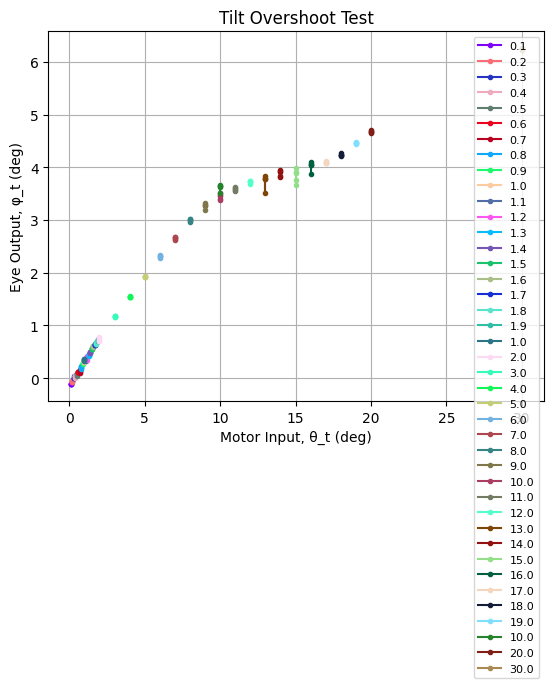

In [17]:
# Parameter
y_org = 219.22972847
tilt_idx = 0


for i in range(len(data_load["data"])):
    input_arr = data_load["data"][i]["input_arr"]
    phi = [px_to_deg_fx(x[1]-y_org) for x in data_load["data"][i]["pixel_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.plot(input_arr, phi, marker='.', linestyle=None, color=rand_colors[i])
# plt.xlim([-2, 4])
# plt.ylim([-2, 6])
plt.grid()
plt.legend(log_cmd_str, fontsize=8)
plt.xlabel('Motor Input, θ_t (deg)')
plt.ylabel('Eye Output, φ_t (deg)')
plt.title('Tilt Overshoot Test')

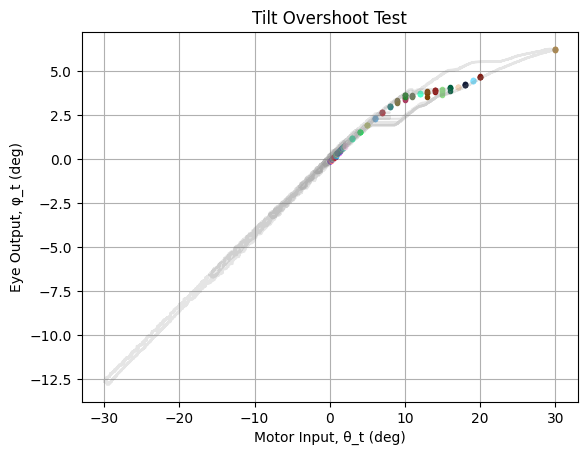

In [19]:
# Data Superposition


# Opening of Pickle File
filename = "20230228_190531_652632_left_1D-BASELINE_EXP20_TiltRobotBaseline.pickle"
fn = os.path.join(os.path.abspath(".."), "results/"+filename)
with open(fn, 'rb') as file:
    baseline_data = pickle.load(file)

# Parameter
y_org = 219.22972847
tilt_idx = 0

# Data Captured
for i in range(len(data_load["data"])):
    input_arr = data_load["data"][i]["input_arr"]
    phi = [px_to_deg_fx(x[1]-y_org) for x in data_load["data"][i]["pixel_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.plot(input_arr, phi, marker='.', linestyle=None, color=rand_colors[i])
# plt.legend(log_cmd_str, fontsize=8)

# Line Data Parameters
for i in range(len(baseline_data["data"])):
    input_arr = baseline_data["data"][i]["input_arr"]
    phi = [px_to_deg_fx(x[1]-y_org) for x in baseline_data["data"][i]["pixel_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.plot(input_arr, phi, color="gray", alpha=0.2)
    
plt.xlabel('Motor Input, θ_t (deg)')
plt.ylabel('Eye Output, φ_t (deg)')
plt.title('Tilt Overshoot Test')
plt.grid()

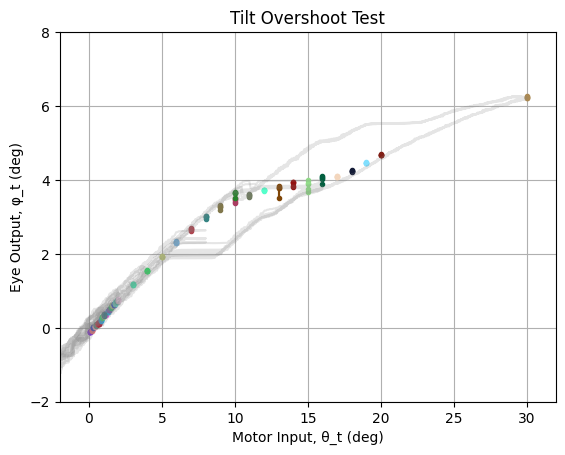

In [24]:
# Data Superposition


# Opening of Pickle File
filename = "20230228_190531_652632_left_1D-BASELINE_EXP20_TiltRobotBaseline.pickle"
fn = os.path.join(os.path.abspath(".."), "results/"+filename)
with open(fn, 'rb') as file:
    baseline_data = pickle.load(file)

# Parameter
y_org = 219.22972847
tilt_idx = 0

# Data Captured
for i in range(len(data_load["data"])):
    input_arr = data_load["data"][i]["input_arr"]
    phi = [px_to_deg_fx(x[1]-y_org) for x in data_load["data"][i]["pixel_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.plot(input_arr, phi, marker='.', linestyle=None, color=rand_colors[i])
# plt.legend(log_cmd_str, fontsize=8)

# Line Data Parameters
for i in range(len(baseline_data["data"])):
    input_arr = baseline_data["data"][i]["input_arr"]
    phi = [px_to_deg_fx(x[1]-y_org) for x in baseline_data["data"][i]["pixel_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.plot(input_arr, phi, color="gray", alpha=0.2)
    
plt.xlabel('Motor Input, θ_t (deg)')
plt.ylabel('Eye Output, φ_t (deg)')
plt.title('Tilt Overshoot Test')
plt.xlim([-2, 32])
plt.ylim([-2, 8])
plt.grid()